In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -------------------------
# Load Dataset
# -------------------------
df = pd.read_csv("Provisional_COVID-19_Deaths_by_Sex_and_Age.csv")

In [31]:
# -------------------------
# Data Cleaning (No Loops)
# -------------------------
death_cols = [
    "COVID-19 Deaths",
    "Pneumonia Deaths",
    "Influenza Deaths",
    "Total Deaths"
]

# Convert selected columns to numeric, coercing invalid values to NaN
df[death_cols] = df[death_cols].apply(pd.to_numeric, errors="coerce")

# Drop rows with missing values in death-related columns
df = df.dropna(subset=death_cols).reset_index(drop=True)

print("Dataset shape after cleaning:", df.shape)


Dataset shape after cleaning: (46467, 16)


In [32]:
# -------------------------
# Encode Categorical Variables
# -------------------------
le = LabelEncoder()
df["State"] = le.fit_transform(df["State"])
df["Sex"] = le.fit_transform(df["Sex"])
df["Age Group"] = le.fit_transform(df["Age Group"])

In [33]:
# -------------------------
# Unsupervised Learning (K-Means Clustering)
# -------------------------
values = df[death_cols]

scaler = StandardScaler()
values_scaled = scaler.fit_transform(values)

kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(values_scaled)

# PCA for 2D visualization
pca = PCA(n_components=2)
pca_values = pca.fit_transform(values_scaled)

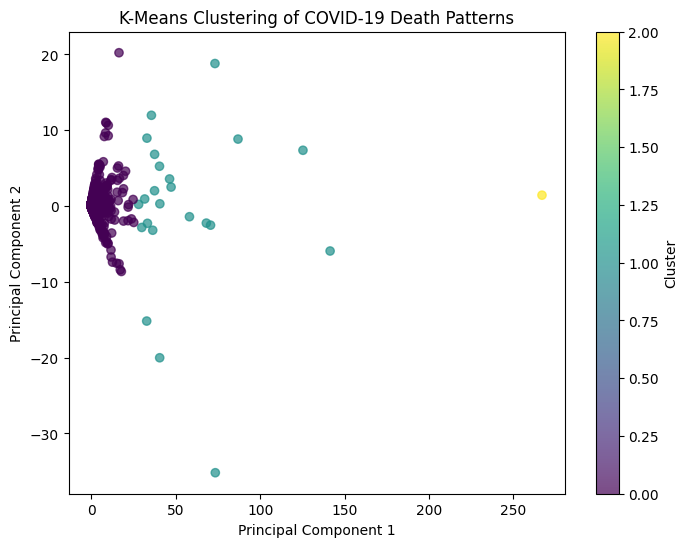

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(
    pca_values[:, 0],
    pca_values[:, 1],
    c=df["Cluster"],
    cmap="viridis",
    alpha=0.7
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clustering of COVID-19 Death Patterns")
plt.colorbar(label="Cluster")
plt.show()

In [18]:
# -------------------------
# Supervised Learning
# -------------------------
# Target variable
y = df["COVID-19 Deaths"]

# Keep only numeric columns for features
X = df.drop(columns=["COVID-19 Deaths"]).select_dtypes(include=[np.number])

print("Features used for training:")
print(X.columns)


Features used for training:
Index(['Year', 'Month', 'State', 'Sex', 'Age Group', 'Total Deaths',
       'Pneumonia Deaths', 'Pneumonia and COVID-19 Deaths', 'Influenza Deaths',
       'Pneumonia, Influenza, or COVID-19 Deaths', 'Cluster'],
      dtype='object')


In [34]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------
# Handle Missing Values (IMPUTATION)
# -------------------------
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
# -------------------------
# Scaling (for SVR)
# -------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [20]:
#MODEL
lr = LinearRegression()

dt = DecisionTreeRegressor(random_state=42)

rf = RandomForestRegressor(
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)

svr = SVR(kernel="linear")

lr.fit(X_train, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Train SVR on smaller subset
svr.fit(X_train_scaled[:5000], y_train[:5000])


,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,1.0
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [35]:
# -------------------------
# Predictions
# -------------------------
lr_pred = lr.predict(X_test)
dt_pred = dt.predict(X_test)
rf_pred = rf.predict(X_test)
svr_pred = svr.predict(X_test_scaled)

In [22]:
# -------------------------
# Evaluation
# -------------------------
results = pd.DataFrame({
    "Model": [
        "Linear Regression",
        "Decision Tree",
        "Random Forest",
        "Support Vector Regressor"
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, lr_pred)),
        np.sqrt(mean_squared_error(y_test, dt_pred)),
        np.sqrt(mean_squared_error(y_test, rf_pred)),
        np.sqrt(mean_squared_error(y_test, svr_pred))
    ],
    "MAE": [
        mean_absolute_error(y_test, lr_pred),
        mean_absolute_error(y_test, dt_pred),
        mean_absolute_error(y_test, rf_pred),
        mean_absolute_error(y_test, svr_pred)
    ],
    "R2 Score": [
        r2_score(y_test, lr_pred),
        r2_score(y_test, dt_pred),
        r2_score(y_test, rf_pred),
        r2_score(y_test, svr_pred)
    ]
})

print(results)

                      Model         RMSE         MAE  R2 Score
0         Linear Regression   104.024528   69.989069  0.999598
1             Decision Tree   860.361247   49.724661  0.972486
2             Random Forest   322.092513   26.617971  0.996144
3  Support Vector Regressor  3788.509613  382.558232  0.466504


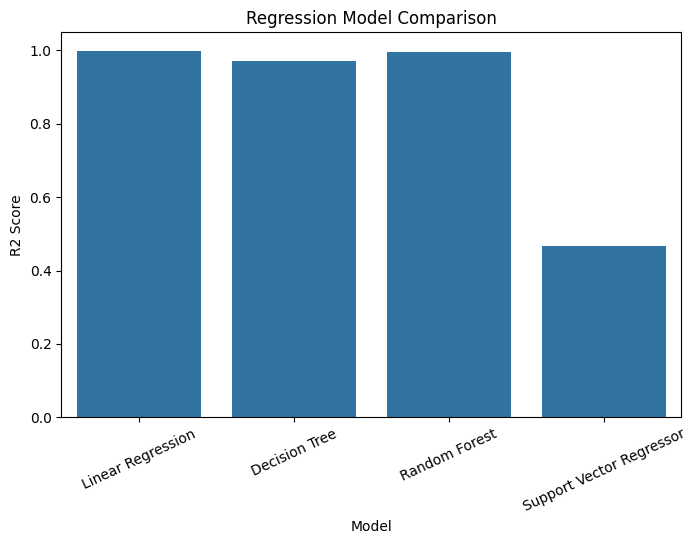

In [23]:
# -------------------------
# Model Comparison Plot
# -------------------------
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="R2 Score", data=results)
plt.xticks(rotation=25)
plt.title("Regression Model Comparison")
plt.show()

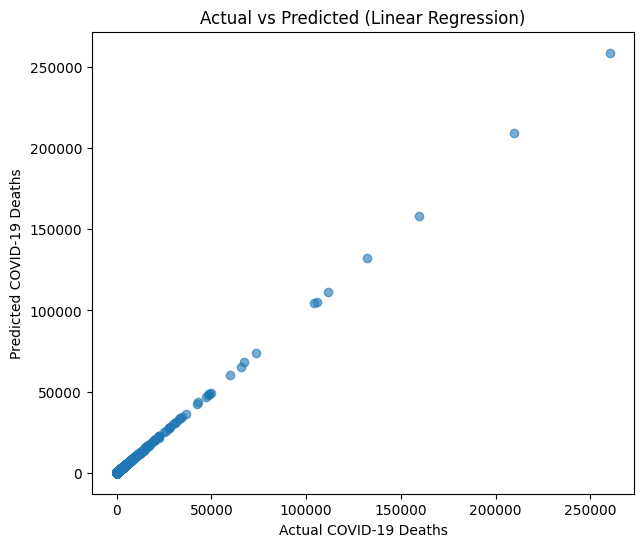

In [24]:
# -------------------------
# Best Model Visualization
# -------------------------
best_model = results.loc[results["R2 Score"].idxmax(), "Model"]

best_pred = (
    svr_pred if best_model == "Support Vector Regressor"
    else rf_pred if best_model == "Random Forest"
    else dt_pred if best_model == "Decision Tree"
    else lr_pred
)

plt.figure(figsize=(7, 6))
plt.scatter(y_test, best_pred, alpha=0.6)
plt.xlabel("Actual COVID-19 Deaths")
plt.ylabel("Predicted COVID-19 Deaths")
plt.title(f"Actual vs Predicted ({best_model})")
plt.show()